In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
def load_data(gas):
    assert gas in ["co2", "ch4"], "gas must be co2 or ch4"

    d_obs4mips = pd.read_csv(f"../satellite-data/datasets/merged_obs4mips_{gas}_df.csv")
    d_emma = pd.read_csv(f"../satellite-data/datasets/merged_emma_{gas}_df.csv")
    d_emma[f"x{gas}"] = d_emma["values"]

    d_gb = pd.read_csv(f"../ground-based-data/datasets/agg_{gas}_2003-present.csv")
    d_gb["year_month"] = pd.to_datetime(d_gb["year_month"])

    return dict(
        obs4mips=d_obs4mips,
        emma=d_emma,
        ground_based=d_gb
    )


In [57]:
def preprocess(dat, algo: str, fill_values: float = 1e20, unit_factor: float = 1e6, gas: str = "xco2"):
    df = pd.DataFrame(dat)
    df["time"] = pd.to_datetime(df.time)

    df[f"{gas}_ppm"] = df[gas]*unit_factor

    df["year"] = df["time"].dt.year
    df["month"] = df["time"].dt.month
    df["year_month"] = df["year"].astype(str) + "/" + df["month"].astype(str)
    df["year_month"] = pd.to_datetime(df["year_month"], format="%Y/%m")

    if gas == "xco2":
        df = df[df.xco2.values != fill_values].reset_index()
    elif gas == "xch4":
        df = df[df.xch4.values != fill_values].reset_index()
    else:
        raise ValueError("Unknown gas type")

    df["hemisphere"] = np.where(df.lat.values > 0, "northern", "southern")
    df=df.groupby(["year_month", "hemisphere"]).agg({f"{gas}_ppm": "mean"}).reset_index()
    df["algo"] = algo
    return df

In [78]:
def plot_obs4mips_emma(dat_shared, gas):
    fig, ax = plt.subplots(figsize = (12,4))
    sns.lineplot(y=f"x{gas}_ppm", x="year_month", hue="algo",
                 style="hemisphere", data=dat_shared)
    plt.show()


def plot_sat_gb(data, gas):
    plt.figure(figsize = (12,4))
    plt.plot(data["obs4mips"]["year_month"], data["obs4mips"][f"x{gas}_ppm"], label="obs4mips")
    plt.plot(data["emma"]["year_month"], data["emma"][f"x{gas}_ppm"], label="emma")
    plt.plot(data["ground_based"]["year_month"], data["ground_based"]["values"], label="ground-based")
    if gas == "co2":
        plt.ylabel("xco2 in ppm")
    elif gas == "ch4":
        plt.ylabel("xch4 in ppb")
    else:
        raise ValueError("gas is not supported")
    plt.legend()
    plt.show()

## Gas: Carbon Dioxide

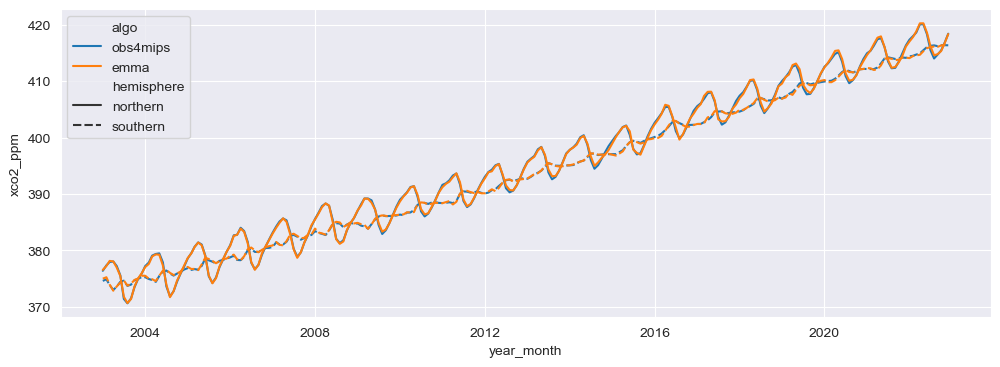

In [76]:
co2_data = load_data("co2")

df_obs4mips = preprocess(co2_data["obs4mips"], "obs4mips")
df_emma = preprocess(co2_data["emma"], "emma", unit_factor=1.)
df_shared = pd.concat([df_obs4mips, df_emma])

plot_obs4mips_emma(df_shared, "co2")

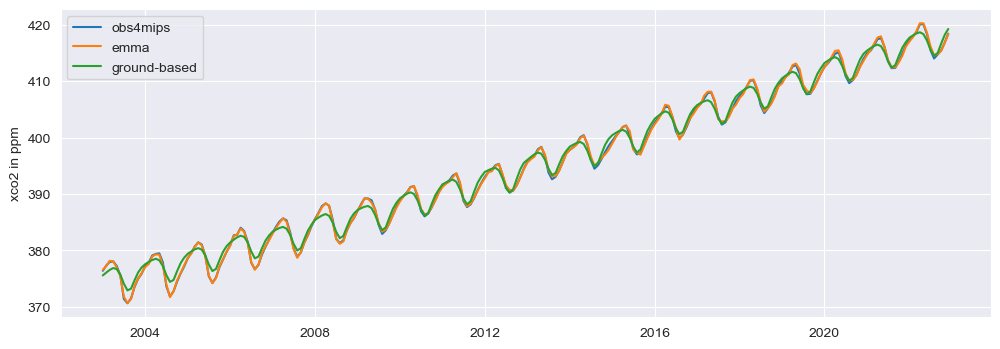

In [79]:
prep_obs4mips = df_obs4mips[df_obs4mips["hemisphere"] == "northern"]
prep_emma = df_emma[df_emma["hemisphere"] == "northern"]
prep_ground_based = co2_data["ground_based"][co2_data["ground_based"]["era"] == "CMIP7"]

prep_data = dict(
    obs4mips = prep_obs4mips,
    emma = prep_emma,
    ground_based = prep_ground_based,
)

plot_sat_gb(prep_data, gas="co2")

## Gas: Methane

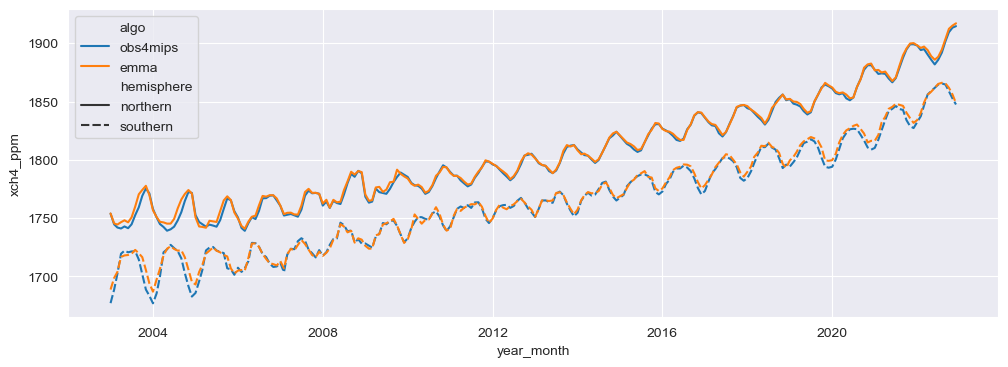

In [96]:
ch4_data = load_data("ch4")

df_obs4mips = preprocess(ch4_data["obs4mips"], "obs4mips", unit_factor=1e9, gas="xch4")
df_emma = preprocess(ch4_data["emma"], "emma", unit_factor=1., gas="xch4")
df_shared = pd.concat([df_obs4mips, df_emma])

plot_obs4mips_emma(df_shared, "ch4")


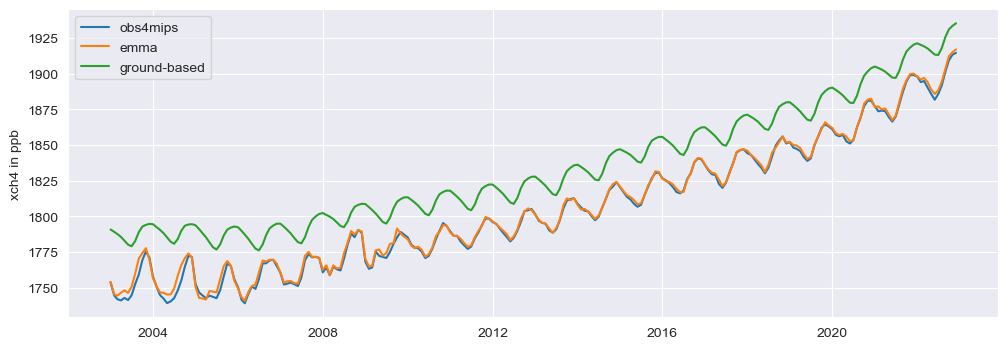

In [97]:
prep_obs4mips = df_obs4mips[df_obs4mips["hemisphere"] == "northern"]
prep_emma = df_emma[df_emma["hemisphere"] == "northern"]
prep_ground_based = ch4_data["ground_based"][ch4_data["ground_based"]["era"] == "CMIP7"]

prep_data = dict(
    obs4mips = prep_obs4mips,
    emma = prep_emma,
    ground_based = prep_ground_based,
)

plot_sat_gb(prep_data, gas="ch4")